In [1]:
import os
if os.getcwd().endswith('/notebook'):
    os.chdir('..')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from model import DynamicDataset, normal_func, Cruys2014
from evaluation import compute_frequency_band_mapping
import seaborn as sns

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
cruys_tanh = Cruys2014()
cruys_normal = Cruys2014(activation_func=normal_func)

In [4]:
cruys_normal.summary()

=== Single model ===
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 3, 50)             650000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 100       
Total params: 665,200
Trainable params: 665,200
Non-trainable params: 0
_________________________________________________________________
=== Contrastive model ===
_________________________________________________________________________________________

In [5]:
train_ds = np.load('output/ukwac-train.npy')
dev_ds = np.load('output/ukwac-dev.npy')

In [6]:
train_ds_dynamic = DynamicDataset(train_ds)
dev_ds_dynamic = DynamicDataset(dev_ds)

def train_epoch(model):
    log = model.fit(*train_ds_dynamic.generate(), 
                         validation_data=dev_ds_dynamic.generate(),
                         batch_size=1000, epochs=1, verbose=1)
    return log.history['loss'][0], log.history['val_loss'][0]

In [7]:
%%time
# "we use mini-batch L-BFGS (Liu and Nocedal, 1989) with 1000 pairs of good and corrupt tuples 
# per batch for training, and train for 10 epochs" (van der Cruys, 2014)
# --> tf.keras doesn't have an implementation of L-BFGS and we couldn't get good results with
# 10 epochs of training so we use a different settings. However, I can't imagine that it makes
# so much a difference.
log = [train_epoch(cruys_tanh) for _ in range(10)]

Train on 6569639 samples, validate on 729960 samples
Epoch 1/1
6569639/6569639 [==============================]6569639/6569639 [==============================] - 130s 20us/step - loss: 1.8316 - contrastive_accuracy: 0.5126 - val_loss: 1.4207 - val_contrastive_accuracy: 0.6060

Train on 6569639 samples, validate on 729960 samples
Epoch 1/1
6569639/6569639 [==============================]6569639/6569639 [==============================] - 137s 21us/step - loss: 1.3027 - contrastive_accuracy: 0.6338 - val_loss: 1.2351 - val_contrastive_accuracy: 0.6503

Train on 6569639 samples, validate on 729960 samples
Epoch 1/1
6569639/6569639 [==============================]6569639/6569639 [==============================] - 138s 21us/step - loss: 1.1830 - contrastive_accuracy: 0.6624 - val_loss: 1.1651 - val_contrastive_accuracy: 0.6666

Train on 6569639 samples, validate on 729960 samples
Epoch 1/1
6569639/6569639 [==============================]6569639/6569639 [==============================] - 140s

In [8]:
%%time
log = [train_epoch(cruys_normal) for _ in range(10)]

Train on 6569639 samples, validate on 729960 samples
Epoch 1/1
6569639/6569639 [==============================]6569639/6569639 [==============================] - 130s 20us/step - loss: 1.7937 - contrastive_accuracy: 0.5213 - val_loss: 1.3927 - val_contrastive_accuracy: 0.6125

Train on 6569639 samples, validate on 729960 samples
Epoch 1/1
6569639/6569639 [==============================]6569639/6569639 [==============================] - 130s 20us/step - loss: 1.2797 - contrastive_accuracy: 0.6393 - val_loss: 1.2201 - val_contrastive_accuracy: 0.6540

Train on 6569639 samples, validate on 729960 samples
Epoch 1/1
6569639/6569639 [==============================]6569639/6569639 [==============================] - 130s 20us/step - loss: 1.1687 - contrastive_accuracy: 0.6657 - val_loss: 1.1527 - val_contrastive_accuracy: 0.6699

Train on 6569639 samples, validate on 729960 samples
Epoch 1/1
6569639/6569639 [==============================]6569639/6569639 [==============================] - 132s

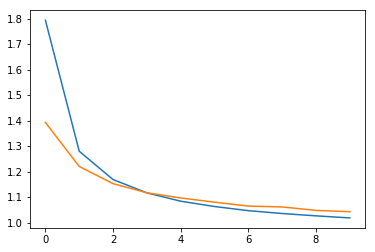

In [9]:
log_df = pd.DataFrame(log, columns=['train_loss', 'dev_loss'])
plt.plot(log_df.train_loss)
_ = plt.plot(log_df.dev_loss)

In [11]:
tf.keras.models.save_model(cruys_tanh.single_model, 'output/cruys2014-tanh-ukwac.hd5')
tf.keras.models.save_model(cruys_normal.single_model, 'output/cruys2014-normal-ukwac.hd5')

# Measure performance

In [12]:
class Evaluator(object):

    def __init__(self, npy_path):
        self.test_ds = np.load(npy_path)
        self.pos_examples = self.test_ds[:,[0,1,2]]
        self.neg_examples = self.test_ds[:,[0,3,4]]

    def __call__(self, model):
        pos_scores = model.predict(self.pos_examples)
        neg_scores = model.predict(self.neg_examples)
        return np.average(pos_scores > neg_scores)

In [13]:
def evaluate(model):
    results = [
        {'dataset': 'ontonotes', 'freq_correction': True,
         'score': Evaluator('output/ontonote-svo-same-freq.npy')(model)},
        {'dataset': 'ontonotes', 'freq_correction': False,
         'score': Evaluator('output/ontonote-svo-unigram-freq.npy')(model)},
        {'dataset': 'ukwac', 'freq_correction': True,
         'score': Evaluator('output/ukwac-dev-same-freq.npy')(model)},
        {'dataset': 'ukwac', 'freq_correction': False,
         'score': Evaluator('output/ukwac-dev-unigram-freq.npy')(model)}]
    return pd.DataFrame(results)

In [14]:
evaluate(cruys_normal)

,dataset,freq_correction,score
0,ontonotes,True,0.576778
1,ontonotes,False,0.575145
2,ukwac,True,0.593558
3,ukwac,False,0.593492


In [15]:
evaluate(cruys_tanh)

,dataset,freq_correction,score
0,ontonotes,True,0.579635
1,ontonotes,False,0.570401
2,ukwac,True,0.607313
3,ukwac,False,0.598791


# Analyze accuracy vs frequency

In [16]:
import math

def compute_frequency_band_id_mapping(series):
    counts = series.value_counts()
    n_tenth = int(math.ceil(len(counts)/10))
    bands = [counts.iloc[i*n_tenth:(i+1)*n_tenth].index.values for i in range(10)]
    assert len(counts) == sum(len(band) for band in bands)
    return {val:band_id for band_id, band in enumerate(bands) for val in band}

sbj2band = compute_frequency_band_id_mapping(pd.Series(train_ds[:,0]))

In [17]:
ev = Evaluator('output/ukwac-dev-same-freq.npy')

In [18]:
pos_scores = cruys_normal.predict(ev.pos_examples)
neg_scores = cruys_normal.predict(ev.neg_examples)
correct = (pos_scores > neg_scores)

In [19]:
sbj_bands = [sbj2band.get(sbj_id, -1) for sbj_id in ev.pos_examples[:,0]]

In [20]:
detail_results = pd.DataFrame({'pos_score': pos_scores.flatten(), 
                               'neg_score': neg_scores.flatten(), 
                               'correct': correct.flatten().astype(float), 
                               'sbj_band': sbj_bands})
detail_results.sample(3)

,pos_score,neg_score,correct,sbj_band
191637,-6.847685,-4.652723,0.0,3
3488,-6.836413,-6.185731,0.0,-1
128606,-5.521473,-4.079194,0.0,0


In [21]:
pos_scores2 = cruys_tanh.predict(ev.pos_examples)
neg_scores2 = cruys_tanh.predict(ev.neg_examples)
correct2 = (pos_scores2 > neg_scores2)

In [22]:
detail_results2 = pd.DataFrame({'pos_score': pos_scores2.flatten(), 
                               'neg_score': neg_scores2.flatten(), 
                               'correct': correct2.flatten().astype(float), 
                               'sbj_band': sbj_bands})
detail_results2.sample(3)

,pos_score,neg_score,correct,sbj_band
561105,-19.472124,-19.498028,1.0,-1
325337,-18.341742,-16.363174,0.0,-1
330149,-18.499228,-18.632544,1.0,9


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


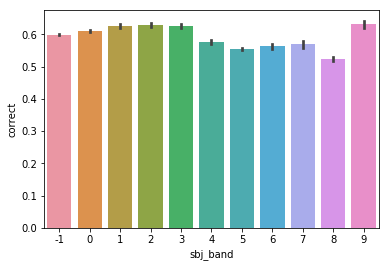

In [23]:
_ = sns.barplot(x='sbj_band', y='correct', data=detail_results)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


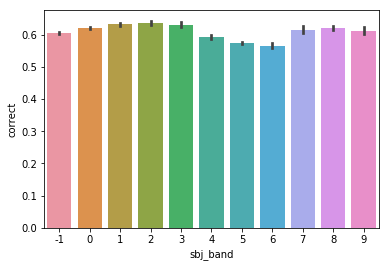

In [24]:
_ = sns.barplot(x='sbj_band', y='correct', data=detail_results2)